# Typical Steam Demand for UIUC

In [1]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Upload data

In [2]:
# define path to data
path = "../../data/" 

In [35]:
# upload datasets
steam15 = pd.read_csv(path+'steamfy15.csv', parse_dates=True, index_col=['Date and Time'])
steam16 = pd.read_csv(path+'steamfy16.csv', parse_dates=True, index_col=['Date and Time'])
steam17 = pd.read_csv(path+'steamfy17.csv', parse_dates=True, index_col=['Date and Time'])
steam18 = pd.read_csv(path+'steamfy18.csv', parse_dates=True, index_col=['Date and Time'])
steam19 = pd.read_csv(path+'steamfy19.csv', parse_dates=True, index_col=['Date and Time'])

## Combine the datasets

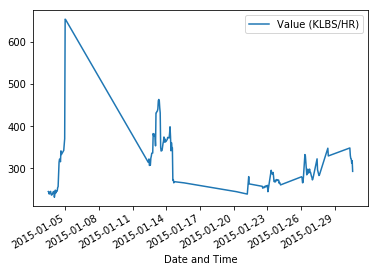

In [29]:
steam15[(steam15['eDNA Status as String'] == 'UNRELIABLE') & (steam15.index.month <= 1)].plot()

In [61]:
frames = [steam15, steam16, steam17, steam18, steam19]

all_data = pd.concat(frames)

# all_data

In [62]:
all_data.head()

,Value (KLBS/HR),eDNA Status as String
Date and Time,,
2014-07-01 00:00:00,105.872467,UNRELIABLE
2014-07-01 01:00:00,104.659416,UNRELIABLE
2014-07-01 02:00:00,105.016411,UNRELIABLE
2014-07-01 03:00:00,106.378754,UNRELIABLE
2014-07-01 04:00:00,106.899544,UNRELIABLE


There is some data marked as 'UNRELIABLE' by eDNA, but it looks mostly okay, except for a couple of days in 2015 that show 0 demand in the winter. We can fix that by interpolating. It looks like the worst data is confined to 2014, which we don't want to use anyway because we can only use complete years of data. 

## Separate the data into complete years

In [63]:
all_data.drop(['eDNA Status as String'], axis=1, inplace=True)

In [64]:
all_data.rename(columns = {'Value (KLBS/HR)':'demand'}, inplace=True)

all_data.head()

,demand
Date and Time,
2014-07-01 00:00:00,105.872467
2014-07-01 01:00:00,104.659416
2014-07-01 02:00:00,105.016411
2014-07-01 03:00:00,106.378754
2014-07-01 04:00:00,106.899544


In [84]:
years = all_data.groupby(all_data.index.year)

steam_data15 = years.get_group(2015)
steam_data16 = years.get_group(2016)
steam_data17 = years.get_group(2017)
steam_data18 = years.get_group(2018)

## Preparing the datasets to be used in RAVEN

This data will be read by RAVEN as HistorySets (a datatype of RAVEN) and will have two columns 

time | demand

where ``time`` is in hours and ``demand`` is in klbs/hr

In [85]:
steam_data15.reset_index(inplace=True)
steam_data15['time'] = steam_data15.index
steam_data15.drop(['Date and Time'], axis=1, inplace=True)
steam_data15.head()

C:\Users\samgd\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\samgd\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\frame.py:3694: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


,demand,time
0,320.324249,0
1,327.812347,1
2,331.560761,2
3,325.336487,3
4,324.881348,4


In [86]:
steam_data16.reset_index(inplace=True)
steam_data16['time'] = steam_data16.index
steam_data16.drop(['Date and Time'], axis=1, inplace=True)
steam_data16 = steam_data16[:8760]
steam_data16.head()

C:\Users\samgd\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\samgd\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\frame.py:3694: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


,demand,time
0,302.318817,0
1,292.156555,1
2,296.997284,2
3,293.854187,3
4,294.685303,4


In [87]:
steam_data17.reset_index(inplace=True)
steam_data17['time'] = steam_data17.index
steam_data17.drop(['Date and Time'], axis=1, inplace=True)
steam_data17.head()

C:\Users\samgd\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\samgd\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\frame.py:3694: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


,demand,time
0,176.952080,0
1,176.582175,1
2,175.337189,2
3,179.603761,3
4,174.753566,4


In [88]:
steam_data18.reset_index(inplace=True)
steam_data18['time'] = steam_data18.index
steam_data18.drop(['Date and Time'], axis=1, inplace=True)
steam_data18.head()

C:\Users\samgd\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\samgd\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\frame.py:3694: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


,demand,time
0,308.428254,0
1,311.191381,1
2,313.863116,2
3,315.728345,3
4,316.977930,4


## Download the RAVEN datasets

In [89]:
steam_data15.to_csv(path+'steam_data15.csv')
steam_data16.to_csv(path+'steam_data16.csv')
steam_data17.to_csv(path+'steam_data17.csv')
steam_data18.to_csv(path+'steam_data18.csv')